Для начала импортируем нужные библиотеки:

In [154]:
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from matplotlib.ticker import MaxNLocator

Теперь переходим к парсингу таблицы "100 самых населённых городских агломераций мира" с сайта Википедия:

In [155]:
url = 'https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D1%81%D0%B0%D0%BC%D1%8B%D1%85_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D1%91%D0%BD%D0%BD%D1%8B%D1%85_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D1%81%D0%BA%D0%B8%D1%85_%D0%B0%D0%B3%D0%BB%D0%BE%D0%BC%D0%B5%D1%80%D0%B0%D1%86%D0%B8%D0%B9'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table', {'class': 'wikitable'})
rows_list = []
rows = table.find_all('tr')[1:]  #Пропускаем заголовок

for row in rows:
    cols = row.find_all('td')
    if len(cols) >= 5:
        city = cols[2].text.strip()
        country = cols[3].text.strip()
        population = cols[4].text.strip().replace('\xa0', '').replace(' ', '')
        area = cols[5].text.strip().replace(',', '.')
        density = cols[6].text.strip().replace('\xa0', '').replace(' ', '')
        rows_list.append({'Город': city, 'Страна': country, 'Население': population,
                          'Площадь (км^2)': area, 'Плотность населения (ч/км^2)': density})

data = pd.DataFrame(rows_list)

data.to_csv('largest_cities.csv', index=False)

Проверяем, что таблица успешно перенесена:

In [156]:
data = pd.read_csv('largest_cities.csv')
data['Население'] = data['Население'] * 1000

data.head()


,Город,Страна,Население,Площадь (км^2),Плотность населения (ч/км^2)
0,Токио — Иокогама,Япония,37785000,8775,4306
1,Джакарта,Индонезия,35386000,3546,9980
2,Дели,Индия,31190000,2344,13307
3,Гуанчжоу — Фошань,Китай,27119000,4543,5970
4,Мумбаи,Индия,25189000,1046,24073


Теперь проверим, есть ли в данных пропуски:

In [157]:
print(data.isnull().sum())

Город                           0
Страна                          0
Население                       0
Площадь (км^2)                  0
Плотность населения (ч/км^2)    0
dtype: int64


Пропусков, как и ожидалось, нет. Тогда переходим к гипотезам!

**Гипотеза 1:** Города с большей площадью имеют меньшую плотность населения.
Эта гипотеза основывается на предположении, что большие по площади города имеют больше пространства для расселения людей, что позволяет распределить жителей на большей территории, снижая плотность населения.

Для проверки гипотезы мы сначала вычислим корреляцию между площадью и плотностью населения городов:

In [158]:
correlation = data[['Площадь (км^2)', 'Плотность населения (ч/км^2)']].corr()

# Печать значений корреляции
print("Корреляция между площадью и плотностью населения:")
correlation_single = correlation.loc[['Площадь (км^2)'], ['Плотность населения (ч/км^2)']]
print(correlation_single)

Корреляция между площадью и плотностью населения:
                Плотность населения (ч/км^2)
Площадь (км^2)                         -0.54


Значение -0.54 говорит о том, что, в общем, чем больше площадь города, тем меньше плотность населения. Тем не менее, корреляция не является очень сильной, так как по модулю не превосходит 0.7.

Рассмотрим зависимость площади и плотности на графике, который выводит названия городов с большой площадью или высокой плотностью населения:

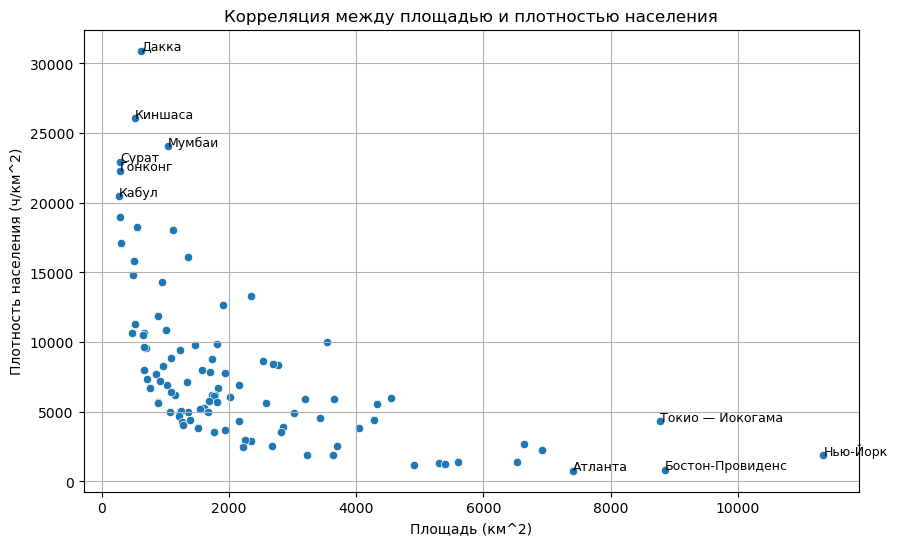

In [159]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Площадь (км^2)', y='Плотность населения (ч/км^2)', data=data)
plt.title('Корреляция между площадью и плотностью населения')
plt.xlabel('Площадь (км^2)')
plt.ylabel('Плотность населения (ч/км^2)')
plt.grid(True)
for i, row in data.iterrows():
    if row['Площадь (км^2)'] > 7000 or row['Плотность населения (ч/км^2)'] > 20000:
        plt.text(row['Площадь (км^2)'], row['Плотность населения (ч/км^2)'], row['Город'], fontsize=9)
plt.show()

In [160]:
На графике прослеживается нисходящий тренд, что подтверждаеи отрицательную корреляцию.

Кроме того, проведем аналитику зависимости при помощи Линейной регрессии:

SyntaxError: invalid syntax (768704406.py, line 1)

In [ ]:
# Подготовка данных для регрессии
X = data['Площадь (км^2)']
y = data['Плотность населения (ч/км^2)']

# Построение модели
model = sm.OLS(y, X).fit()

coefficients = model.params
print("Коэффициенты регрессии:")
print(coefficients)

Полученный коэффициент регрессии означает, что при увеличении площади на 1 квадратный километр, 
плотность населения уменьшается на 1.23 человека на квадратный километр. Таким образом, наша гипотеза подтвердилась.

**Гипотеза 2:** Страны, которые чаще всего встречаются в списке, имеют в среднем большую плотность населения по городам.
Для того чтобы проверить гипотезу, построим график, который будет отражать информацию как о средней плотности по стране, так и о количестве вхождений страны в рейтинг:

C:\Users\boris\AppData\Local\Temp\ipykernel_20100\809069630.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



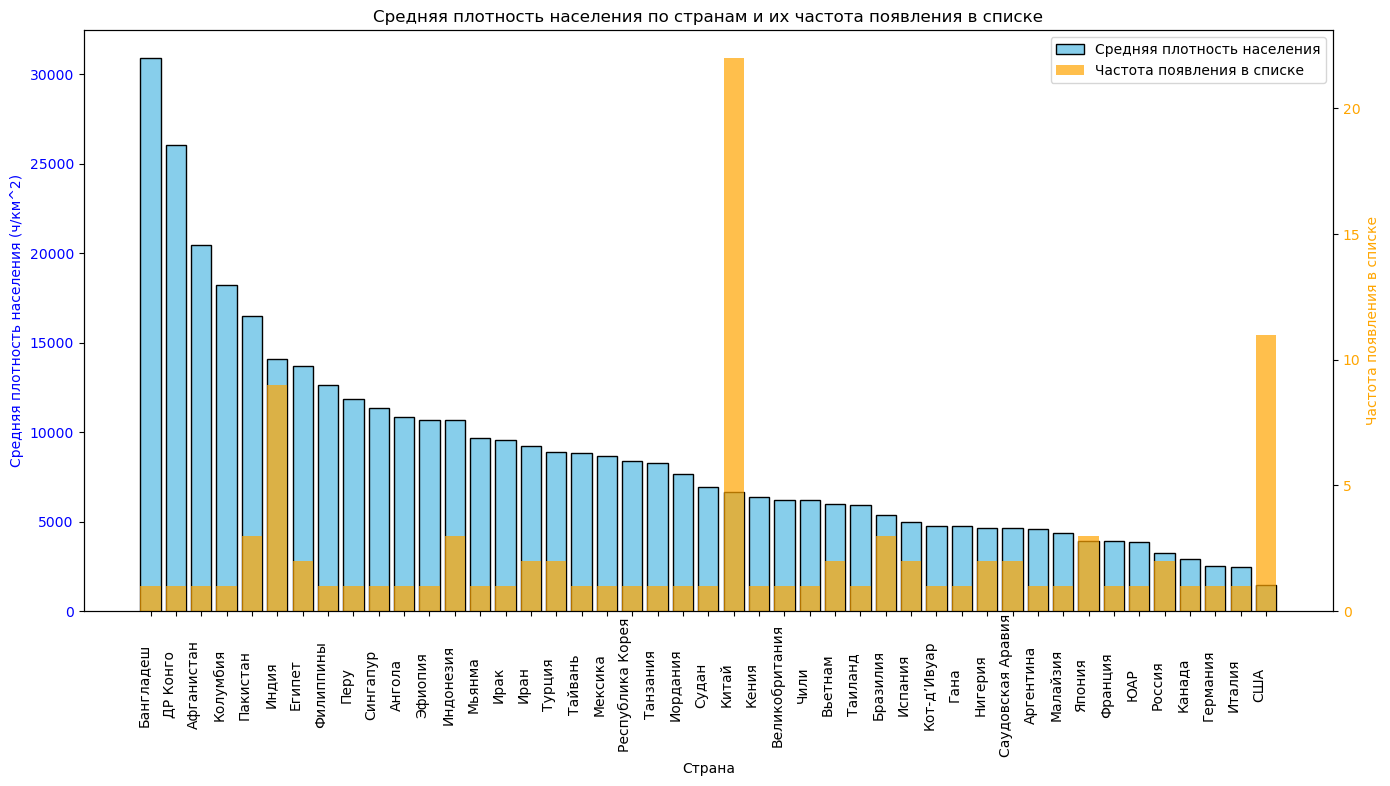

In [162]:
country_count = data['Страна'].value_counts()

# Сортировка частоты появления стран в том же порядке, что и средняя плотность населения
country_count_sorted = country_count.loc[country_avg_density_sorted.index]

# Создание графика
fig, ax1 = plt.subplots(figsize=(14, 8))

# Построение графика средней плотности населения
ax1.bar(country_avg_density_sorted.index, country_avg_density_sorted.values, color='skyblue', edgecolor='black', label='Средняя плотность населения')

# Добавление второй оси y для отображения частоты появления стран в списке
ax2 = ax1.twinx()
ax2.bar(country_count_sorted.index, country_count_sorted.values, color='orange', alpha=0.7, label='Частота появления в списке')

# Настройка осей и заголовков
ax1.set_xlabel('Страна')
ax1.set_ylabel('Средняя плотность населения (ч/км^2)', color='blue')
ax2.set_ylabel('Частота появления в списке', color='orange')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')
ax1.set_title('Средняя плотность населения по странам и их частота появления в списке')

# Растянем ось X и установим вертикальное положение меток
ax1.set_xticklabels(country_avg_density_sorted.index, rotation=90, ha='right', va='center', y=-0.11)

# Добавление легенды в правом верхнем углу
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

# Отображение графика
plt.tight_layout()
plt.show()

Мы получили интересный результат! Желтые столбцы, которые отражают частоту появления страны в списке, не совпадают с синими, которые отражают среднюю плотность. То есть то, как мноо в стране городов с высоким населением, не связано со средней плотностью населения в этой стране (по городам из топ-100). Этот эффект может возникнуть из-за того, что у многих стран единственный сильно населенный город - это столица. Например, поэтому с точки зрения средней плотности лидиирует Бангладеш с единственном городом-столицей Дакка. А вот Китай, большая страна с развитой экономикой, по средней плотности находится в середине, но зато упоминается в списке наибольшее количество раз.

Убедиться в таком выводе можно, составив гистограмму плотностей населения по странам:

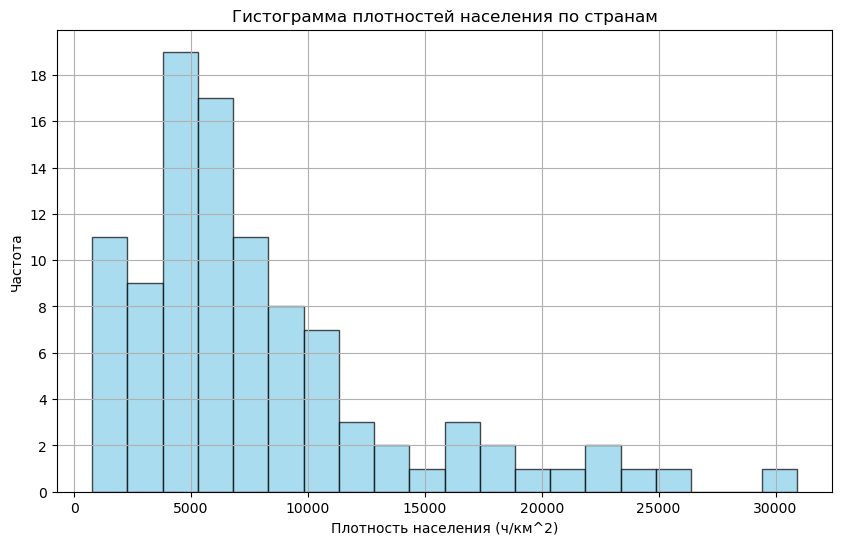

In [161]:
plt.figure(figsize=(10, 6))
plt.hist(data['Плотность населения (ч/км^2)'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Гистограмма плотностей населения по странам')
plt.xlabel('Плотность населения (ч/км^2)')
plt.ylabel('Частота')
plt.grid(True)

# Настройка оси Y для отображения только целых чисел
ax = plt.gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

Гистограмма отражает количество стран, которые попадают в интервал плотности населения. Мы видим, что наибольшее
количество находится в интервале 0-10000, а дальше количество резко падает. Таким образом, гипотеза о том, что 
страны, которые чаще всего встречаются в списке, имеют в среднем большую плотность населения по городам, опровергнута.

In [169]:
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium.plugins import MarkerCluster



# Инициализация Nominatim
geolocator = Nominatim(user_agent="city_geocoder")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Функция для получения координат
def get_coordinates(city, country):
    location = geocode(f"{city}, {country}")
    if location:
        return location.latitude, location.longitude
    else:
        return None, None

# Применение функции ко всем строкам DataFrame
data[['Широта', 'Долгота']] = data.apply(lambda row: pd.Series(get_coordinates(row['Город'], row['Страна'])), axis=1)


In [172]:
print(data)

               Город     Страна  Население  Площадь (км^2)  \
0   Токио — Иокогама     Япония   37785000            8775   
1           Джакарта  Индонезия   35386000            3546   
2               Дели      Индия   31190000            2344   
4             Мумбаи      Индия   25189000            1046   
5             Манила  Филиппины   24156000            1911   
..               ...        ...        ...             ...   
95     Белу-Оризонти   Бразилия    5242000            1287   
96           Тайюань      Китай    5067000             886   
97             Чанша      Китай    5065000             754   
98             Хэфэй      Китай    5052000             894   
99            Мешхед       Иран    5045000             474   

    Плотность населения (ч/км^2)  Широта  Долгота  
0                           4306   35.50   139.56  
1                           9980   -6.18   106.83  
2                          13307   28.63    77.17  
4                          24073   19.08    72.

In [171]:
data = data.dropna(subset=['Широта', 'Долгота'])

In [170]:
m = folium.Map(location=[20, 0], zoom_start=2)

# Добавление кластеров маркеров
marker_cluster = MarkerCluster().add_to(m)

# Добавление точек на карту
for idx, row in data.iterrows():
    folium.Marker([row['Широта'], row['Долгота']],
                  popup=f"{row['Город']}, {row['Страна']}<br>Население: {row['Население']}<br>Площадь: {row['Площадь (км^2)']} км^2<br>Плотность: {row['Плотность населения (ч/км^2)']} ч/км^2").add_to(marker_cluster)

# Сохранение карты в HTML файл
m.save("world_cities.html")

# Отображение карты в блокноте (например, в Jupyter)
m